In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
import xarray as xr
import numpy as np
import pop_tools 
import utils
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='04:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(6) 
client

Client Scheduler: tcp://128.117.208.174:46051 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/33795/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### x1 annual means

(I know this is clunky because I write out netcdfs and then read them back in again, but you can just do chunks of new years without redoing the old ones, so I'm leaving it)

In [16]:
start_yr = 1850
end_yr = 2100
ens_mem = '1101.006'

### First write out annual means by individual files

In [17]:
%%time

for year in np.arange(start_yr,end_yr+1):
    print(year)
    yr4="{:04d}".format(year)
    path = '/glade/derecho/scratch/kristenk/feisty_output/CESM2-LENS/' + ens_mem + '/hist/CESM2-LENS.' + ens_mem + '_' + yr4 + '.zarr'
    
    ds_tmp = xr.open_zarr(path, consolidated=False)
    
    ds_tmp = ds_tmp.mean(dim='time')
    
    file = '/glade/derecho/scratch/kristenk/FEISTY_CESM2-le/FEISTY-CESM2-LENS.' + ens_mem +'_' + yr4 + '.nc'
    
    ds_tmp.to_netcdf(file, mode='w')

1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049


In [18]:
ds_grid_x1 = pop_tools.get_grid('POP_gx1v7')
lons_x1=ds_grid_x1.TLONG
lats_x1=ds_grid_x1.TLAT
area_x1=ds_grid_x1.TAREA
area_m_x1=ds_grid_x1.TAREA * 1e-4
lons_norm_x1 = utils.normal_lons(lons_x1)

### Then read it all in again as one dataset

In [19]:
path = '/glade/derecho/scratch/kristenk/FEISTY_CESM2-le'

files = sorted(glob(f'{path}/FEISTY-CESM2-LENS.' + ens_mem +'_????.nc'))
        
ds_feisty_x1=xr.open_mfdataset(files,concat_dim="time", coords='minimal', compat="override", combine='nested')

In [20]:
ds_feisty_x1

,Array,Chunk
Bytes,2.07 GiB,8.44 MiB
Shape,"(251, 9, 384, 320)","(1, 9, 384, 320)"
Count,1004 Tasks,251 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,1.84 GiB,7.50 MiB
Shape,"(251, 8, 384, 320)","(1, 8, 384, 320)"
Count,1004 Tasks,251 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [21]:
ds_feisty_x1.biomass.attrs['units'] = 'g WW/m^2'
ds_feisty_x1.production.attrs['units'] = 'g WW/m^2/d'
ds_feisty_x1.fish_yield.attrs['units'] = 'g WW/m^2/d'

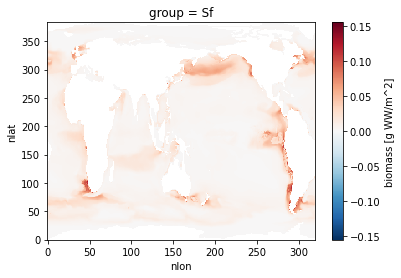

In [22]:
ds_feisty_x1.biomass.isel(time=29,group=0).plot()

### Now write it out

In [23]:
out_dir = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY/'

In [24]:
ds_feisty_x1.to_netcdf(out_dir + 'CESM2-LE-FEISTY-HIST-SSP370-cmip6-ensmem-' + ens_mem + '_1850-2100.nc', mode='w')

In [23]:
#cluster.close()